In [1]:
import numpy as np
import pandas as pd

from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans

import wrangle as wr
import preprocessing as pr
import explore as ex
import model as mo

import warnings
warnings.filterwarnings("ignore")


Bad key "text.kerning_factor" on line 4 in
/usr/local/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
pd.set_option("display.max_columns", None)
plt.rc("figure", figsize=(16, 8))

In [3]:
# Helper function used to updated the scaled arrays and transform them into usable dataframes
def return_values(scaler, df):
    scaled_df = pd.DataFrame(scaler.transform(df), columns=df.columns.values).set_index([df.index.values])
    return scaler, scaled_df

# Linear scaler
def min_max_scaler(df):
    scaler = MinMaxScaler().fit(df)
    scaler, scaled_df = return_values(scaler, df)
    return scaler, scaled_df

In [4]:
# testing the updated get_model_df function
model_df = pr.get_model_df()

# calling add_new_features that Daniel created
model_df = pr.add_new_features(model_df)
print(model_df.shape)

(13603, 22)


In [5]:
# creating city_state ID
model_df["city_state"] = model_df["city"] + "_" + model_df["state"]

# creating city_mask varible using the value counts of the years for each city_state
city_mask = model_df.groupby("city_state").year.count()

# masking the city_mask variable to only include city_states where there are 15 year observations
# by doing this we ensure that we are working with city_states that have data for 2006-2020 Q2 
city_mask = city_mask[city_mask == 15]

# write a function to shrink the df
def in_city_mask(x):
    return x in city_mask

# apply city mask to shrink the df
model_df = model_df[model_df.city_state.apply(in_city_mask)]

# sort_values of model_df by city, state, and year
model_df = model_df.sort_values(["city", "state", "year"])

# reseting index
model_df.reset_index(inplace=True)

# drop original index
model_df.drop(columns=["index"], inplace=True)
print(model_df.shape)
model_df.head(16)

(390, 23)


,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume_pop,market_volume_delta_pop,market_volume_nc,market_volume_delta_nc,ei_pop,ei_nc,city_state
0,Atlanta,GA,2006,6,33186800,5.531133e+06,4457100.0,2.0,9181100.0,4590550.0,4590550.0,False,NaN,NaN,NaN,NaN,7088073068,NaN,1.665922e+09,NaN,NaN,NaN,Atlanta_GA
1,Atlanta,GA,2007,9,29105800,3.233978e+06,2990200.0,2.0,4541700.0,2270850.0,2270850.0,False,-0.122971,-0.505321,0.500000,0.0,5203386464,-0.265895,1.506388e+09,-0.095764,1.194693,0.547069,Atlanta_GA
2,Atlanta,GA,2008,2,6735000,3.367500e+06,3367500.0,1.0,4950000.0,4950000.0,4950000.0,False,-0.768603,0.089900,-0.777778,-0.5,4593331384,-0.117242,1.804818e+09,0.198110,0.262130,0.909683,Atlanta_GA
3,Atlanta,GA,2009,9,49972900,5.552544e+06,4400000.0,1.0,3750000.0,3750000.0,3750000.0,False,6.419881,-0.242424,3.500000,0.0,8138285946,0.771761,3.172588e+09,0.757844,4.187856,0.430969,Atlanta_GA
4,Atlanta,GA,2010,11,68788385,6.253490e+06,5196100.0,2.0,7203500.0,3601750.0,3601750.0,False,0.376514,0.920933,0.222222,1.0,16444346058,1.020615,4.640094e+09,0.462558,0.681235,1.313407,Atlanta_GA
5,Atlanta,GA,2011,10,56215900,5.621590e+06,4341850.0,2.0,9274500.0,4637250.0,4637250.0,False,-0.182770,0.287499,-0.090909,0.0,17678683423,0.075062,3.341105e+09,-0.279949,0.760170,1.788066,Atlanta_GA
6,Atlanta,GA,2012,12,56365900,4.697158e+06,3250100.0,1.0,3000000.0,3000000.0,3000000.0,False,0.002668,-0.676532,0.200000,-0.5,22203696331,0.255959,2.989158e+09,-0.105338,0.798329,0.361553,Atlanta_GA
7,Atlanta,GA,2013,19,138582800,7.293832e+06,6133600.0,NaN,NaN,NaN,NaN,False,1.458628,0.000000,0.583333,0.0,25474256780,0.147298,2.264148e+09,-0.242547,2.142973,1.320214,Atlanta_GA
8,Atlanta,GA,2014,11,106803300,9.709391e+06,4919700.0,1.0,15861400.0,15861400.0,15861400.0,False,-0.229318,4.287133,-0.421053,0.0,16642823555,-0.346681,2.284783e+09,0.009114,1.179641,5.239381,Atlanta_GA
9,Atlanta,GA,2015,4,20900000,5.225000e+06,5750000.0,1.0,5500000.0,5500000.0,5500000.0,False,-0.804313,-0.653246,-0.636364,0.0,13777111433,-0.172189,2.871268e+09,0.256692,0.236391,0.275926,Atlanta_GA


In [6]:
model_df["nc_ratio"] = model_df.total_mortgage_volume_nc / model_df.total_mortgage_volume_pop

model_df[
    ((model_df.city == "Atlanta") & (model_df.state == "GA"))
    | ((model_df.city == "Austin") & (model_df.state == "TX"))
].sort_values(by=["city", "state", "year"])

,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume_pop,market_volume_delta_pop,market_volume_nc,market_volume_delta_nc,ei_pop,ei_nc,city_state,nc_ratio
0,Atlanta,GA,2006,6,33186800,5.531133e+06,4457100.0,2.0,9181100.0,4.590550e+06,4590550.0,False,NaN,NaN,NaN,NaN,7088073068,NaN,1.665922e+09,NaN,NaN,NaN,Atlanta_GA,0.276649
1,Atlanta,GA,2007,9,29105800,3.233978e+06,2990200.0,2.0,4541700.0,2.270850e+06,2270850.0,False,-0.122971,-0.505321,0.500000,0.000000,5203386464,-0.265895,1.506388e+09,-0.095764,1.194693,0.547069,Atlanta_GA,0.156041
2,Atlanta,GA,2008,2,6735000,3.367500e+06,3367500.0,1.0,4950000.0,4.950000e+06,4950000.0,False,-0.768603,0.089900,-0.777778,-0.500000,4593331384,-0.117242,1.804818e+09,0.198110,0.262130,0.909683,Atlanta_GA,0.734967
3,Atlanta,GA,2009,9,49972900,5.552544e+06,4400000.0,1.0,3750000.0,3.750000e+06,3750000.0,False,6.419881,-0.242424,3.500000,0.000000,8138285946,0.771761,3.172588e+09,0.757844,4.187856,0.430969,Atlanta_GA,0.075041
4,Atlanta,GA,2010,11,68788385,6.253490e+06,5196100.0,2.0,7203500.0,3.601750e+06,3601750.0,False,0.376514,0.920933,0.222222,1.000000,16444346058,1.020615,4.640094e+09,0.462558,0.681235,1.313407,Atlanta_GA,0.104720
5,Atlanta,GA,2011,10,56215900,5.621590e+06,4341850.0,2.0,9274500.0,4.637250e+06,4637250.0,False,-0.182770,0.287499,-0.090909,0.000000,17678683423,0.075062,3.341105e+09,-0.279949,0.760170,1.788066,Atlanta_GA,0.164980
6,Atlanta,GA,2012,12,56365900,4.697158e+06,3250100.0,1.0,3000000.0,3.000000e+06,3000000.0,False,0.002668,-0.676532,0.200000,-0.500000,22203696331,0.255959,2.989158e+09,-0.105338,0.798329,0.361553,Atlanta_GA,0.053224
7,Atlanta,GA,2013,19,138582800,7.293832e+06,6133600.0,NaN,NaN,NaN,NaN,False,1.458628,0.000000,0.583333,0.000000,25474256780,0.147298,2.264148e+09,-0.242547,2.142973,1.320214,Atlanta_GA,NaN
8,Atlanta,GA,2014,11,106803300,9.709391e+06,4919700.0,1.0,15861400.0,1.586140e+07,15861400.0,False,-0.229318,4.287133,-0.421053,0.000000,16642823555,-0.346681,2.284783e+09,0.009114,1.179641,5.239381,Atlanta_GA,0.148510
9,Atlanta,GA,2015,4,20900000,5.225000e+06,5750000.0,1.0,5500000.0,5.500000e+06,5500000.0,False,-0.804313,-0.653246,-0.636364,0.000000,13777111433,-0.172189,2.871268e+09,0.256692,0.236391,0.275926,Atlanta_GA,0.263158


In [7]:
model_df.nc_ratio.fillna(value=0, inplace=True)
model_df[model_df.nc_ratio == 0]

,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume_pop,market_volume_delta_pop,market_volume_nc,market_volume_delta_nc,ei_pop,ei_nc,city_state,nc_ratio
7,Atlanta,GA,2013,19,138582800,7.293832e+06,6133600.0,NaN,NaN,NaN,NaN,False,1.458628,0.0,0.583333,0.0,25474256780,0.147298,2.264148e+09,-0.242547,2.142973,1.320214,Atlanta_GA,0.0
12,Atlanta,GA,2018,3,61088500,2.036283e+07,14888500.0,NaN,NaN,NaN,NaN,False,-0.645409,0.0,-0.571429,0.0,20223485898,-0.056959,6.127089e+09,0.200106,0.376008,0.833259,Atlanta_GA,0.0
15,Austin,TX,2006,1,14083843,1.408384e+07,14083843.0,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,7088073068,NaN,1.665922e+09,NaN,NaN,NaN,Austin_TX,0.0
16,Austin,TX,2007,1,14375300,1.437530e+07,14375300.0,NaN,NaN,NaN,NaN,False,0.020694,NaN,0.000000,NaN,5203386464,-0.265895,1.506388e+09,-0.095764,1.390394,NaN,Austin_TX,0.0
17,Austin,TX,2008,1,2635000,2.635000e+06,2635000.0,NaN,NaN,NaN,NaN,False,-0.816699,NaN,0.000000,NaN,4593331384,-0.117242,1.804818e+09,0.198110,0.207645,NaN,Austin_TX,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,Tampa,FL,2015,3,22813900,7.604633e+06,8596500.0,NaN,NaN,NaN,NaN,False,-0.614292,0.0,-0.400000,0.0,13777111433,-0.172189,2.871268e+09,0.256692,0.465937,0.795740,Tampa_FL,0.0
371,Tampa,FL,2017,2,66444000,3.322200e+07,33222000.0,NaN,NaN,NaN,NaN,False,-0.154787,0.0,-0.333333,0.0,21444975319,0.314027,5.105455e+09,0.454527,0.643224,0.687509,Tampa_FL,0.0
372,Tampa,FL,2018,2,10125500,5.062750e+06,5062750.0,NaN,NaN,NaN,NaN,False,-0.847609,0.0,0.000000,0.0,20223485898,-0.056959,6.127089e+09,0.200106,0.161596,0.833259,Tampa_FL,0.0
376,Washington,DC,2007,2,5551100,2.775550e+06,2775550.0,NaN,NaN,NaN,NaN,False,-0.840150,0.0,-0.500000,0.0,5203386464,-0.265895,1.506388e+09,-0.095764,0.217748,1.105905,Washington_DC,0.0


In [8]:
model_df.ei_pop.mean()

2.013746211352902

In [9]:
model_df["ei_zscore_pop"] = (model_df["ei_pop"] - model_df["ei_pop"].mean()) / model_df["ei_pop"].std()
model_df

,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume_pop,market_volume_delta_pop,market_volume_nc,market_volume_delta_nc,ei_pop,ei_nc,city_state,nc_ratio,ei_zscore_pop
0,Atlanta,GA,2006,6,33186800,5.531133e+06,4457100.0,2.0,9181100.0,4590550.0,4590550.0,False,NaN,NaN,NaN,NaN,7088073068,NaN,1.665922e+09,NaN,NaN,NaN,Atlanta_GA,0.276649,NaN
1,Atlanta,GA,2007,9,29105800,3.233978e+06,2990200.0,2.0,4541700.0,2270850.0,2270850.0,False,-0.122971,-0.505321,0.500000,0.000000,5203386464,-0.265895,1.506388e+09,-0.095764,1.194693,0.547069,Atlanta_GA,0.156041,-0.237189
2,Atlanta,GA,2008,2,6735000,3.367500e+06,3367500.0,1.0,4950000.0,4950000.0,4950000.0,False,-0.768603,0.089900,-0.777778,-0.500000,4593331384,-0.117242,1.804818e+09,0.198110,0.262130,0.909683,Atlanta_GA,0.734967,-0.507248
3,Atlanta,GA,2009,9,49972900,5.552544e+06,4400000.0,1.0,3750000.0,3750000.0,3750000.0,False,6.419881,-0.242424,3.500000,0.000000,8138285946,0.771761,3.172588e+09,0.757844,4.187856,0.430969,Atlanta_GA,0.075041,0.629598
4,Atlanta,GA,2010,11,68788385,6.253490e+06,5196100.0,2.0,7203500.0,3601750.0,3601750.0,False,0.376514,0.920933,0.222222,1.000000,16444346058,1.020615,4.640094e+09,0.462558,0.681235,1.313407,Atlanta_GA,0.104720,-0.385880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,Washington,DC,2016,8,312836100,3.910451e+07,27352400.0,2.0,54704800.0,27352400.0,27352400.0,False,0.445886,2.402124,0.000000,0.000000,16320043780,0.184577,3.510044e+09,0.222472,1.220593,2.782989,Washington_DC,0.174867,-0.229688
386,Washington,DC,2017,8,137557300,1.719466e+07,11693000.0,1.0,12735000.0,12735000.0,12735000.0,False,-0.560290,-0.767205,0.000000,-0.500000,21444975319,0.314027,5.105455e+09,0.454527,0.334628,0.160049,Washington_DC,0.092580,-0.486254
387,Washington,DC,2018,7,169249000,2.417843e+07,25450000.0,3.0,46635000.0,15545000.0,15235000.0,False,0.230389,2.661955,-0.125000,2.000000,20223485898,-0.056959,6.127089e+09,0.200106,1.304704,3.051359,Washington_DC,0.275541,-0.205331
388,Washington,DC,2019,5,61723450,1.234469e+07,9300000.0,1.0,18333450.0,18333450.0,18333450.0,False,-0.635310,-0.606874,-0.285714,-0.666667,17830952288,-0.118305,5.779693e+09,-0.056698,0.413624,0.416756,Washington_DC,0.297026,-0.463377


In [10]:
model_df = model_df[model_df.year > 2006]
model_df

,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume_pop,market_volume_delta_pop,market_volume_nc,market_volume_delta_nc,ei_pop,ei_nc,city_state,nc_ratio,ei_zscore_pop
1,Atlanta,GA,2007,9,29105800,3.233978e+06,2990200.0,2.0,4541700.0,2270850.0,2270850.0,False,-0.122971,-0.505321,0.500000,0.000000,5203386464,-0.265895,1.506388e+09,-0.095764,1.194693,0.547069,Atlanta_GA,0.156041,-0.237189
2,Atlanta,GA,2008,2,6735000,3.367500e+06,3367500.0,1.0,4950000.0,4950000.0,4950000.0,False,-0.768603,0.089900,-0.777778,-0.500000,4593331384,-0.117242,1.804818e+09,0.198110,0.262130,0.909683,Atlanta_GA,0.734967,-0.507248
3,Atlanta,GA,2009,9,49972900,5.552544e+06,4400000.0,1.0,3750000.0,3750000.0,3750000.0,False,6.419881,-0.242424,3.500000,0.000000,8138285946,0.771761,3.172588e+09,0.757844,4.187856,0.430969,Atlanta_GA,0.075041,0.629598
4,Atlanta,GA,2010,11,68788385,6.253490e+06,5196100.0,2.0,7203500.0,3601750.0,3601750.0,False,0.376514,0.920933,0.222222,1.000000,16444346058,1.020615,4.640094e+09,0.462558,0.681235,1.313407,Atlanta_GA,0.104720,-0.385880
5,Atlanta,GA,2011,10,56215900,5.621590e+06,4341850.0,2.0,9274500.0,4637250.0,4637250.0,False,-0.182770,0.287499,-0.090909,0.000000,17678683423,0.075062,3.341105e+09,-0.279949,0.760170,1.788066,Atlanta_GA,0.164980,-0.363022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,Washington,DC,2016,8,312836100,3.910451e+07,27352400.0,2.0,54704800.0,27352400.0,27352400.0,False,0.445886,2.402124,0.000000,0.000000,16320043780,0.184577,3.510044e+09,0.222472,1.220593,2.782989,Washington_DC,0.174867,-0.229688
386,Washington,DC,2017,8,137557300,1.719466e+07,11693000.0,1.0,12735000.0,12735000.0,12735000.0,False,-0.560290,-0.767205,0.000000,-0.500000,21444975319,0.314027,5.105455e+09,0.454527,0.334628,0.160049,Washington_DC,0.092580,-0.486254
387,Washington,DC,2018,7,169249000,2.417843e+07,25450000.0,3.0,46635000.0,15545000.0,15235000.0,False,0.230389,2.661955,-0.125000,2.000000,20223485898,-0.056959,6.127089e+09,0.200106,1.304704,3.051359,Washington_DC,0.275541,-0.205331
388,Washington,DC,2019,5,61723450,1.234469e+07,9300000.0,1.0,18333450.0,18333450.0,18333450.0,False,-0.635310,-0.606874,-0.285714,-0.666667,17830952288,-0.118305,5.779693e+09,-0.056698,0.413624,0.416756,Washington_DC,0.297026,-0.463377


In [11]:
model_df[((model_df.city == "San Francisco") & (model_df.state == "CA"))]

,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume_pop,market_volume_delta_pop,market_volume_nc,market_volume_delta_nc,ei_pop,ei_nc,city_state,nc_ratio,ei_zscore_pop
316,San Francisco,CA,2007,2,80270600,4.013530e+07,40135300.0,NaN,NaN,NaN,NaN,False,9.193092,NaN,1.000000,NaN,5203386464,-0.265895,1.506388e+09,-0.095764,13.885069,NaN,San Francisco_CA,0.000000,3.437802
317,San Francisco,CA,2008,1,1601300,1.601300e+06,1601300.0,NaN,NaN,NaN,NaN,False,-0.980051,NaN,-0.500000,NaN,4593331384,-0.117242,1.804818e+09,0.198110,0.022598,NaN,San Francisco_CA,0.000000,-0.576614
318,San Francisco,CA,2009,2,9111100,4.555550e+06,4555550.0,NaN,NaN,NaN,NaN,False,4.689815,NaN,1.000000,NaN,8138285946,0.771761,3.172588e+09,0.757844,3.211389,NaN,San Francisco_CA,0.000000,0.346824
319,San Francisco,CA,2010,4,37115400,9.278850e+06,1713400.0,NaN,NaN,NaN,NaN,False,3.073646,NaN,1.000000,NaN,16444346058,1.020615,4.640094e+09,0.462558,2.016042,NaN,San Francisco_CA,0.000000,0.000665
320,San Francisco,CA,2011,6,173590400,2.893173e+07,25912150.0,1.0,70000000.0,70000000.0,70000000.0,False,3.677045,NaN,0.500000,NaN,17678683423,0.075062,3.341105e+09,-0.279949,4.350491,NaN,San Francisco_CA,0.403248,0.676695
321,San Francisco,CA,2012,4,79588700,1.989718e+07,19353300.0,NaN,NaN,NaN,NaN,False,-0.541514,0.000000,-0.333333,0.0,22203696331,0.255959,2.989158e+09,-0.105338,0.365048,1.117741,San Francisco_CA,0.000000,-0.477444
322,San Francisco,CA,2013,1,4888000,4.888000e+06,4888000.0,NaN,NaN,NaN,NaN,False,-0.938584,0.000000,-0.750000,0.0,25474256780,0.147298,2.264148e+09,-0.242547,0.053531,1.320214,San Francisco_CA,0.000000,-0.567656
323,San Francisco,CA,2014,2,115669400,5.783470e+07,57834700.0,1.0,58084400.0,58084400.0,58084400.0,False,22.663953,-0.170223,1.000000,0.0,16642823555,-0.346681,2.284783e+09,0.009114,36.221114,0.822283,San Francisco_CA,0.502159,9.906070
324,San Francisco,CA,2015,2,23294500,1.164725e+07,11647250.0,NaN,NaN,NaN,NaN,False,-0.798611,0.000000,0.000000,0.0,13777111433,-0.172189,2.871268e+09,0.256692,0.243279,0.795740,San Francisco_CA,0.000000,-0.512708
325,San Francisco,CA,2016,1,39882800,3.988280e+07,39882800.0,NaN,NaN,NaN,NaN,False,0.712112,0.000000,-0.500000,0.0,16320043780,0.184577,3.510044e+09,0.222472,1.445337,0.818015,San Francisco_CA,0.000000,-0.164605


In [12]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364 entries, 1 to 389
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   city                         364 non-null    object 
 1   state                        364 non-null    object 
 2   year                         364 non-null    int64  
 3   quantity_of_mortgages_pop    364 non-null    int64  
 4   total_mortgage_volume_pop    364 non-null    int64  
 5   average_mortgage_volume_pop  364 non-null    float64
 6   median_mortgage_amount_pop   364 non-null    float64
 7   quantity_of_mortgages_nc     169 non-null    float64
 8   total_mortgage_volume_nc     169 non-null    float64
 9   average_mortgage_volume_nc   169 non-null    float64
 10  median_mortgage_amount_nc    169 non-null    float64
 11  label                        364 non-null    bool   
 12  city_state_vol_delta_pop     364 non-null    float64
 13  city_state_vol_delta

In [13]:
model_df.ei_zscore_pop.mean()

-5.256784019069937e-16

In [14]:
scaler = MinMaxScaler()
scaler.fit(model_df[["ei_pop", "nc_ratio"]])
model_df[["ei_pop", "nc_ratio"]] = scaler.transform(model_df[["ei_pop", "nc_ratio"]])

In [15]:
scaler

MinMaxScaler(copy=True, feature_range=(0, 1))

In [16]:
model_df[["ei_pop", "nc_ratio"]]

,ei_pop,nc_ratio
1,0.032380,0.156041
2,0.006617,0.734967
3,0.115067,0.075041
4,0.018195,0.104720
5,0.020376,0.164980
...,...,...
385,0.033095,0.174867
386,0.008620,0.092580
387,0.035419,0.275541
388,0.010802,0.297026


In [17]:
X = model_df[["ei_pop", "nc_ratio"]]

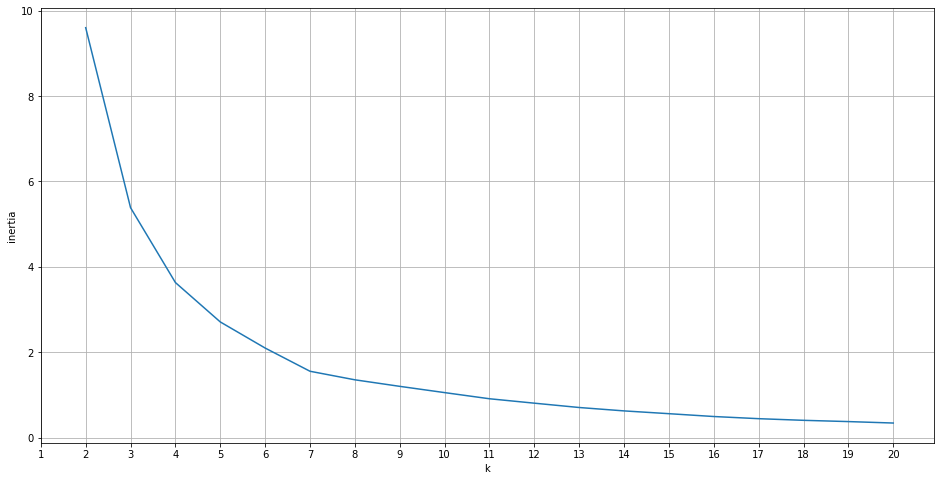

In [18]:
pd.Series({k: ex.get_inertia(k, X) for k in range(2, 21)}).plot()
plt.grid()
plt.xlabel("k")
plt.ylabel("inertia")
plt.xticks(range(1, 21))
plt.show()

## Three Clusters

In [19]:
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(X)

model_df["cluster"] = kmeans.predict(X)

In [20]:
centriods = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centriods

,ei_pop,nc_ratio
0,0.049555,0.026329
1,0.064552,0.863403
2,0.071238,0.375545


In [21]:
model_df.groupby("cluster")["ei_pop", "nc_ratio"].mean()

,ei_pop,nc_ratio
cluster,,
0,0.049555,0.026329
1,0.064552,0.863403
2,0.071238,0.375545


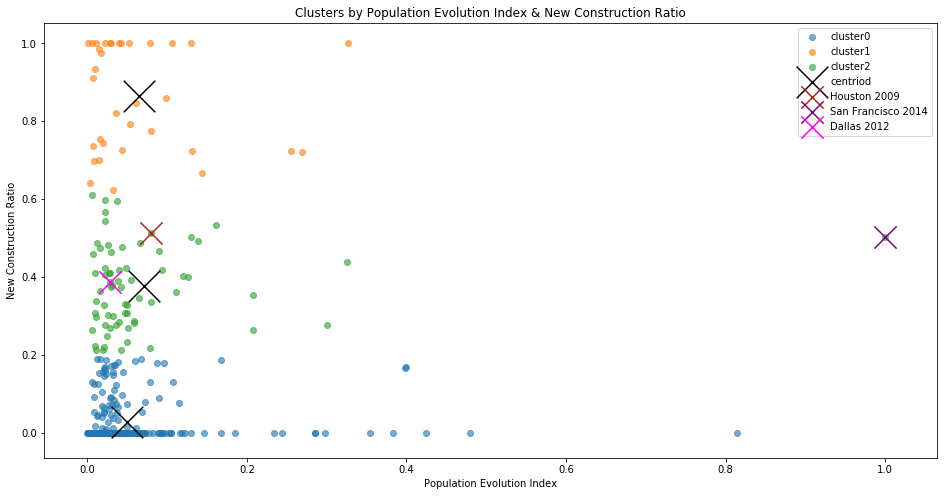

In [22]:
for cluster, subset in model_df.groupby("cluster"):
    plt.scatter(
        subset.ei_pop, subset.nc_ratio, label="cluster" + str(cluster), alpha=0.6
    )

centriods.plot.scatter(
    x="ei_pop",
    y="nc_ratio",
    c="black",
    marker="x",
    s=1000,
    ax=plt.gca(),
    label="centriod",
)

houston_2009 = model_df[(model_df.city == "Houston") & (model_df.state == "TX") & (model_df.year == 2009)]

houston_2009.plot.scatter(
    x="ei_pop",
    y="nc_ratio",
    c="firebrick",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="Houston 2009",
)

# seattle not in dataset
# seattle_2010 = model_df[(model_df.city == "Seattle") & (model_df.state == "WA") & (model_df.year == 2010)]

# seattle_2010.plot.scatter(
#     x="ei_pop",
#     y="nc_ratio",
#     c="purple",
#     marker="x",
#     s=2000,
#     ax=plt.gca(),
#     label="Seattle 2010",
# )

df_2014 = model_df[(model_df.city == "San Francisco") & (model_df.state == "CA") & (model_df.year == 2014)]

df_2014.plot.scatter(
    x="ei_pop",
    y="nc_ratio",
    c="purple",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="San Francisco 2014",
)

dallas_2012 = model_df[(model_df.city == "Dallas") & (model_df.state == "TX")  & (model_df.year == 2012)]

dallas_2012.plot.scatter(
    x="ei_pop",
    y="nc_ratio",
    c="magenta",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="Dallas 2012",
)

plt.legend()
plt.title("Clusters by Population Evolution Index & New Construction Ratio")
plt.xlabel("Population Evolution Index")
plt.ylabel("New Construction Ratio")
plt.show()

In [23]:
model_df

,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume_pop,market_volume_delta_pop,market_volume_nc,market_volume_delta_nc,ei_pop,ei_nc,city_state,nc_ratio,ei_zscore_pop,cluster
1,Atlanta,GA,2007,9,29105800,3.233978e+06,2990200.0,2.0,4541700.0,2270850.0,2270850.0,False,-0.122971,-0.505321,0.500000,0.000000,5203386464,-0.265895,1.506388e+09,-0.095764,0.032380,0.547069,Atlanta_GA,0.156041,-0.237189,0
2,Atlanta,GA,2008,2,6735000,3.367500e+06,3367500.0,1.0,4950000.0,4950000.0,4950000.0,False,-0.768603,0.089900,-0.777778,-0.500000,4593331384,-0.117242,1.804818e+09,0.198110,0.006617,0.909683,Atlanta_GA,0.734967,-0.507248,1
3,Atlanta,GA,2009,9,49972900,5.552544e+06,4400000.0,1.0,3750000.0,3750000.0,3750000.0,False,6.419881,-0.242424,3.500000,0.000000,8138285946,0.771761,3.172588e+09,0.757844,0.115067,0.430969,Atlanta_GA,0.075041,0.629598,0
4,Atlanta,GA,2010,11,68788385,6.253490e+06,5196100.0,2.0,7203500.0,3601750.0,3601750.0,False,0.376514,0.920933,0.222222,1.000000,16444346058,1.020615,4.640094e+09,0.462558,0.018195,1.313407,Atlanta_GA,0.104720,-0.385880,0
5,Atlanta,GA,2011,10,56215900,5.621590e+06,4341850.0,2.0,9274500.0,4637250.0,4637250.0,False,-0.182770,0.287499,-0.090909,0.000000,17678683423,0.075062,3.341105e+09,-0.279949,0.020376,1.788066,Atlanta_GA,0.164980,-0.363022,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,Washington,DC,2016,8,312836100,3.910451e+07,27352400.0,2.0,54704800.0,27352400.0,27352400.0,False,0.445886,2.402124,0.000000,0.000000,16320043780,0.184577,3.510044e+09,0.222472,0.033095,2.782989,Washington_DC,0.174867,-0.229688,0
386,Washington,DC,2017,8,137557300,1.719466e+07,11693000.0,1.0,12735000.0,12735000.0,12735000.0,False,-0.560290,-0.767205,0.000000,-0.500000,21444975319,0.314027,5.105455e+09,0.454527,0.008620,0.160049,Washington_DC,0.092580,-0.486254,0
387,Washington,DC,2018,7,169249000,2.417843e+07,25450000.0,3.0,46635000.0,15545000.0,15235000.0,False,0.230389,2.661955,-0.125000,2.000000,20223485898,-0.056959,6.127089e+09,0.200106,0.035419,3.051359,Washington_DC,0.275541,-0.205331,2
388,Washington,DC,2019,5,61723450,1.234469e+07,9300000.0,1.0,18333450.0,18333450.0,18333450.0,False,-0.635310,-0.606874,-0.285714,-0.666667,17830952288,-0.118305,5.779693e+09,-0.056698,0.010802,0.416756,Washington_DC,0.297026,-0.463377,2


---
## Six Clusters

In [24]:
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(X)

model_df["cluster"] = kmeans.predict(X)

In [25]:
centriods = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centriods

,ei_pop,nc_ratio
0,0.451941,0.092799
1,0.035162,0.026046
2,0.064552,0.863403
3,0.053690,0.375120


In [26]:
model_df.groupby("cluster")["ei_pop", "nc_ratio"].mean()

,ei_pop,nc_ratio
cluster,,
0,0.451941,0.092799
1,0.035162,0.026046
2,0.064552,0.863403
3,0.053690,0.375120


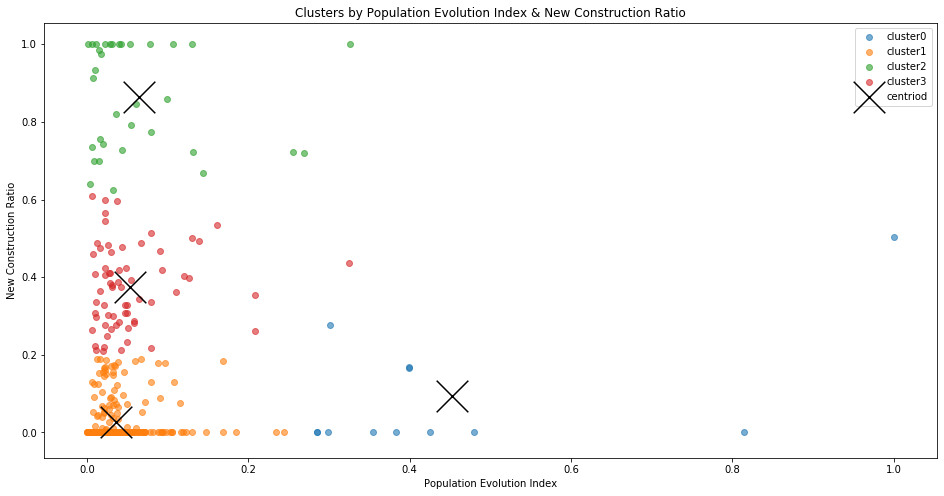

In [27]:
for cluster, subset in model_df.groupby("cluster"):
    plt.scatter(
        subset.ei_pop, subset.nc_ratio, label="cluster" + str(cluster), alpha=0.6
    )

centriods.plot.scatter(
    x="ei_pop",
    y="nc_ratio",
    c="black",
    marker="x",
    s=1000,
    ax=plt.gca(),
    label="centriod",
)

plt.legend()
plt.title("Clusters by Population Evolution Index & New Construction Ratio")
plt.xlabel("Population Evolution Index")
plt.ylabel("New Construction Ratio")
plt.show()

---
## Using Z-Score of EI & NC Ratio

In [28]:
model_df

,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume_pop,market_volume_delta_pop,market_volume_nc,market_volume_delta_nc,ei_pop,ei_nc,city_state,nc_ratio,ei_zscore_pop,cluster
1,Atlanta,GA,2007,9,29105800,3.233978e+06,2990200.0,2.0,4541700.0,2270850.0,2270850.0,False,-0.122971,-0.505321,0.500000,0.000000,5203386464,-0.265895,1.506388e+09,-0.095764,0.032380,0.547069,Atlanta_GA,0.156041,-0.237189,1
2,Atlanta,GA,2008,2,6735000,3.367500e+06,3367500.0,1.0,4950000.0,4950000.0,4950000.0,False,-0.768603,0.089900,-0.777778,-0.500000,4593331384,-0.117242,1.804818e+09,0.198110,0.006617,0.909683,Atlanta_GA,0.734967,-0.507248,2
3,Atlanta,GA,2009,9,49972900,5.552544e+06,4400000.0,1.0,3750000.0,3750000.0,3750000.0,False,6.419881,-0.242424,3.500000,0.000000,8138285946,0.771761,3.172588e+09,0.757844,0.115067,0.430969,Atlanta_GA,0.075041,0.629598,1
4,Atlanta,GA,2010,11,68788385,6.253490e+06,5196100.0,2.0,7203500.0,3601750.0,3601750.0,False,0.376514,0.920933,0.222222,1.000000,16444346058,1.020615,4.640094e+09,0.462558,0.018195,1.313407,Atlanta_GA,0.104720,-0.385880,1
5,Atlanta,GA,2011,10,56215900,5.621590e+06,4341850.0,2.0,9274500.0,4637250.0,4637250.0,False,-0.182770,0.287499,-0.090909,0.000000,17678683423,0.075062,3.341105e+09,-0.279949,0.020376,1.788066,Atlanta_GA,0.164980,-0.363022,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,Washington,DC,2016,8,312836100,3.910451e+07,27352400.0,2.0,54704800.0,27352400.0,27352400.0,False,0.445886,2.402124,0.000000,0.000000,16320043780,0.184577,3.510044e+09,0.222472,0.033095,2.782989,Washington_DC,0.174867,-0.229688,1
386,Washington,DC,2017,8,137557300,1.719466e+07,11693000.0,1.0,12735000.0,12735000.0,12735000.0,False,-0.560290,-0.767205,0.000000,-0.500000,21444975319,0.314027,5.105455e+09,0.454527,0.008620,0.160049,Washington_DC,0.092580,-0.486254,1
387,Washington,DC,2018,7,169249000,2.417843e+07,25450000.0,3.0,46635000.0,15545000.0,15235000.0,False,0.230389,2.661955,-0.125000,2.000000,20223485898,-0.056959,6.127089e+09,0.200106,0.035419,3.051359,Washington_DC,0.275541,-0.205331,3
388,Washington,DC,2019,5,61723450,1.234469e+07,9300000.0,1.0,18333450.0,18333450.0,18333450.0,False,-0.635310,-0.606874,-0.285714,-0.666667,17830952288,-0.118305,5.779693e+09,-0.056698,0.010802,0.416756,Washington_DC,0.297026,-0.463377,3


In [29]:
model_df[["ei_pop", "nc_ratio"]] = scaler.inverse_transform(model_df[["ei_pop", "nc_ratio"]])
model_df

,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume_pop,market_volume_delta_pop,market_volume_nc,market_volume_delta_nc,ei_pop,ei_nc,city_state,nc_ratio,ei_zscore_pop,cluster
1,Atlanta,GA,2007,9,29105800,3.233978e+06,2990200.0,2.0,4541700.0,2270850.0,2270850.0,False,-0.122971,-0.505321,0.500000,0.000000,5203386464,-0.265895,1.506388e+09,-0.095764,1.194693,0.547069,Atlanta_GA,0.156041,-0.237189,1
2,Atlanta,GA,2008,2,6735000,3.367500e+06,3367500.0,1.0,4950000.0,4950000.0,4950000.0,False,-0.768603,0.089900,-0.777778,-0.500000,4593331384,-0.117242,1.804818e+09,0.198110,0.262130,0.909683,Atlanta_GA,0.734967,-0.507248,2
3,Atlanta,GA,2009,9,49972900,5.552544e+06,4400000.0,1.0,3750000.0,3750000.0,3750000.0,False,6.419881,-0.242424,3.500000,0.000000,8138285946,0.771761,3.172588e+09,0.757844,4.187856,0.430969,Atlanta_GA,0.075041,0.629598,1
4,Atlanta,GA,2010,11,68788385,6.253490e+06,5196100.0,2.0,7203500.0,3601750.0,3601750.0,False,0.376514,0.920933,0.222222,1.000000,16444346058,1.020615,4.640094e+09,0.462558,0.681235,1.313407,Atlanta_GA,0.104720,-0.385880,1
5,Atlanta,GA,2011,10,56215900,5.621590e+06,4341850.0,2.0,9274500.0,4637250.0,4637250.0,False,-0.182770,0.287499,-0.090909,0.000000,17678683423,0.075062,3.341105e+09,-0.279949,0.760170,1.788066,Atlanta_GA,0.164980,-0.363022,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,Washington,DC,2016,8,312836100,3.910451e+07,27352400.0,2.0,54704800.0,27352400.0,27352400.0,False,0.445886,2.402124,0.000000,0.000000,16320043780,0.184577,3.510044e+09,0.222472,1.220593,2.782989,Washington_DC,0.174867,-0.229688,1
386,Washington,DC,2017,8,137557300,1.719466e+07,11693000.0,1.0,12735000.0,12735000.0,12735000.0,False,-0.560290,-0.767205,0.000000,-0.500000,21444975319,0.314027,5.105455e+09,0.454527,0.334628,0.160049,Washington_DC,0.092580,-0.486254,1
387,Washington,DC,2018,7,169249000,2.417843e+07,25450000.0,3.0,46635000.0,15545000.0,15235000.0,False,0.230389,2.661955,-0.125000,2.000000,20223485898,-0.056959,6.127089e+09,0.200106,1.304704,3.051359,Washington_DC,0.275541,-0.205331,3
388,Washington,DC,2019,5,61723450,1.234469e+07,9300000.0,1.0,18333450.0,18333450.0,18333450.0,False,-0.635310,-0.606874,-0.285714,-0.666667,17830952288,-0.118305,5.779693e+09,-0.056698,0.413624,0.416756,Washington_DC,0.297026,-0.463377,3


In [30]:
X = model_df[["ei_zscore_pop", "nc_ratio"]]

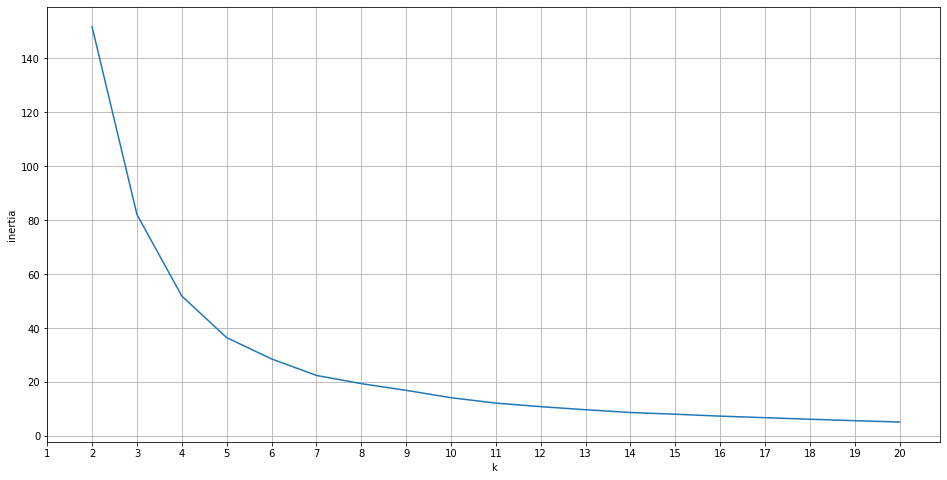

In [31]:
pd.Series({k: ex.get_inertia(k, X) for k in range(2, 21)}).plot()
plt.grid()
plt.xlabel("k")
plt.ylabel("inertia")
plt.xticks(range(1, 21))
plt.show()

## Three Clusters

In [32]:
kmeans = KMeans(n_clusters=5, random_state=123)
kmeans.fit(X)

model_df["cluster"] = kmeans.predict(X)

In [33]:
centriods = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centriods

,ei_zscore_pop,nc_ratio
0,-0.310358,0.051164
1,2.870770,0.218231
2,8.935125,0.251079
3,0.630006,0.239927
4,-0.267947,0.662485


In [34]:
model_df.groupby("cluster")["ei_zscore_pop", "nc_ratio"].mean()

,ei_zscore_pop,nc_ratio
cluster,,
0,-0.310358,0.051164
1,2.870770,0.218231
2,8.935125,0.251079
3,0.630006,0.239927
4,-0.267947,0.662485


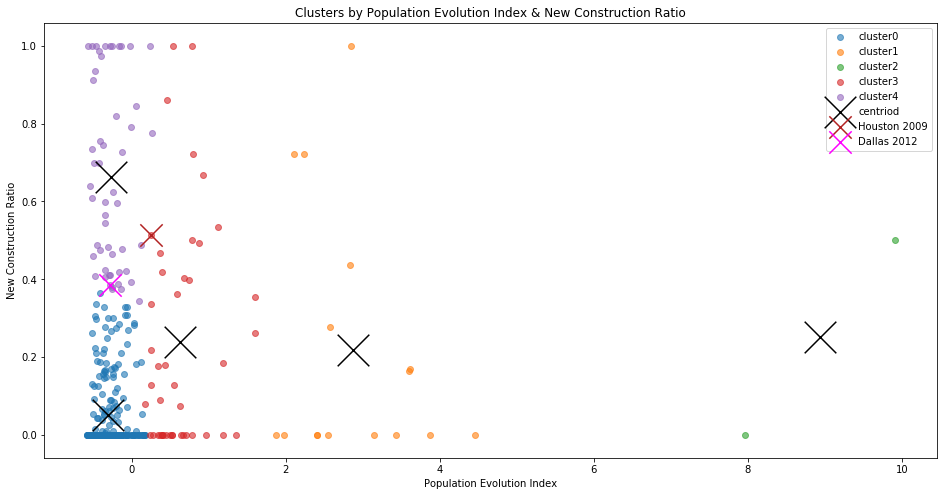

In [35]:
for cluster, subset in model_df.groupby("cluster"):
    plt.scatter(
        subset.ei_zscore_pop, subset.nc_ratio, label="cluster" + str(cluster), alpha=0.6
    )

centriods.plot.scatter(
    x="ei_zscore_pop",
    y="nc_ratio",
    c="black",
    marker="x",
    s=1000,
    ax=plt.gca(),
    label="centriod",
)

houston_2009 = model_df[(model_df.city == "Houston") & (model_df.state == "TX") & (model_df.year == 2009)]

houston_2009.plot.scatter(
    x="ei_zscore_pop",
    y="nc_ratio",
    c="firebrick",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="Houston 2009",
)

dallas_2012 = model_df[(model_df.city == "Dallas") & (model_df.state == "TX")  & (model_df.year == 2012)]

dallas_2012.plot.scatter(
    x="ei_zscore_pop",
    y="nc_ratio",
    c="magenta",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="Dallas 2012",
)

plt.legend()
plt.title("Clusters by Population Evolution Index & New Construction Ratio")
plt.xlabel("Population Evolution Index")
plt.ylabel("New Construction Ratio")
plt.show()